# Veltri Case Study 


File that describes the Antimicrobial peptides case study using Veltri study.
First, with only the sequence itself we built a similar model used by Veltri.
Secondly, using this same dataset we apply a similar strategy as the AmPEP study and
discuss the differences.
Veltri et al. utilized DL to recognize antimicrobial activity. The model proposed captures position invariant patterns
 along an amino acid sequence through the use of convolution and LSTM layers.

The collection of data divided in train test eval is available at
https://www.dveltri.com/ascan/v2/news.html

D. Veltri, U. Kamath, A. Shehu, Deep learning improves antimicrobial
peptide recognition, Bioinformatics 34 (16) (2018) 2740{2747. doi:10.1093/bioinformatics/bty179.


In [1]:
%load_ext autoreload
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import pandas as pd
import sys

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, MaxPool1D, Dropout, Input
from tensorflow.keras.layers import Embedding, Bidirectional
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.preprocessing import StandardScaler

from Bio.SeqIO.FastaIO import SimpleFastaParser

sys.path.append('../../src')

from propythia.sequence import ReadSequence
from propythia.descriptors import Descriptor
from propythia.preprocess import Preprocess
from propythia.feature_selection import FeatureSelection
from propythia.shallow_ml import ShallowML
from propythia.deep_ml import DeepML
from propythia.manifold import Manifold


Training, test and validation sets used by Veltri were downloaded. The datasets are comprised of 712 AMPs for training, 354 for tuning and 712 for test. Non AMPs have the same number, so the dataset is balanced.
First, we retrieve the datasets available for this case study. As they are fasta files, we preprocess them, add the labels, 
transform it to csv and concatenate positives with negatives. 

In [2]:
# GET datasets
amp_eval_file = 'datasets/AMP.eval.fa'
amp_test_file = 'datasets/AMP.te.fa'
amp_train_file = 'datasets/AMP.tr.fa'

non_amp_eval_file = 'datasets/DECOY.eval.fa'
non_amp_test_file = 'datasets/DECOY.te.fa'
non_amp_train_file = 'datasets/DECOY.tr.fa'


#as there are 6 files fasta to process, we made a function to ease the process
def fasta_to_df(file, label):
    identifiers = []
    seq = []
    lab=[]
    with open(file) as fasta_file:  # Will close handle cleanly
        for title, sequence in SimpleFastaParser(fasta_file):
            identifiers.append(title.split(None, 1)[0])  # First word is ID
            seq.append(sequence)
            lab.append(label)
    df = pd.DataFrame(list(zip(identifiers, seq, lab)), columns=['identifiers', 'seq', 'label'])
    return df

amp_eval = fasta_to_df(file=amp_eval_file, label=1)
amp_test = fasta_to_df(file=amp_test_file, label=1)
amp_train = fasta_to_df(file=amp_train_file, label=1)
non_amp_eval = fasta_to_df(file=non_amp_eval_file, label=0)
non_amp_test = fasta_to_df(file=non_amp_test_file, label=0)
non_amp_train = fasta_to_df(file=non_amp_train_file, label=0)


eval = pd.concat([amp_eval, non_amp_eval])
train = pd.concat([amp_train, non_amp_train])
test = pd.concat([amp_test, non_amp_test])

eval = shuffle(eval)
train = shuffle(train)
test = shuffle(test)


In [5]:
# find the maximum len os the sequences. As described in article the sequences do not exceed 183 aminoacids. 
print(max(train.seq.apply(len)))
print(max(test.seq.apply(len)))
print(max(eval.seq.apply(len)))

158
183
172


The sequences of aminoacids are going to be transformed in a categorical encoding, where each aminoacid is represented by a  numeric value. The letter X of the alphabet is marked as a 0. The sequences are pre pad with 0.0 to 200 len aa. 

In [3]:
# PAD ZEROS 200 20 aa  X = 0 categorcial encoding
def pad_sequence(df):
    sequences = df['seq'].tolist()
    alphabet = "XARNDCEQGHILKMFPSTWYV"
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    # {'X': 0,
    #  'A': 1,
    #  'R': 2,
    #  'N': 3,
    #  'D': 4,...
    sequences_integer_ecoded = []
    for seq in sequences:
        integer_encoded = [char_to_int[char] for char in seq]
        sequences_integer_ecoded.append(integer_encoded)
    fps_x = pad_sequences(sequences_integer_ecoded, maxlen=200, padding='pre', value=0.0)   
    return fps_x
    # array([[ 0,  0,  0, ...,  8,  1, 11],
    #        [ 0,  0,  0, ...,  8, 16,  5],
    #        [ 0,  0,  0, ..., 12, 17,  5],
    #        ...,
    #        [ 0,  0,  0, ...,  1, 20,  3],
    #        [ 0,  0,  0, ..., 16, 20,  4],
    #        [ 0,  0,  0, ...,  3, 11,  9]], dtype=int32)


x_eval = pad_sequence(eval)
x_train = pad_sequence(train)
x_test = pad_sequence(test)


In [7]:
print(x_eval.shape)
print(x_train.shape)
print(x_test.shape)

(708, 200)
(1424, 200)
(1424, 200)


As the model does not resemble any of the basic architectures available in ProPythia, we built the model accordingly to the article

In [4]:
def veltri_model(units=100):
    model = Sequential()
    model.add(Input(shape=(200,)))
    model.add(Embedding(input_dim=21, output_dim=128, input_length=200, mask_zero=True))
    model.add(Conv1D(
        filters=64,
        kernel_size=16,
        strides=1,
        padding='same',
        activation='relu'))
    model.add(MaxPool1D(pool_size=5, strides=1, padding='same'))
    model.add(LSTM(units=units,
                   dropout=0.1,
                   unroll=True,
                   return_sequences=False,
                   stateful=False))

    # Add Classification Dense, Compile model and make it ready for optimization
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

A similar model architecture to the one described in the original paper was constructed with one embedding layer (output dimension of 128), one convolutional 1D layer (64 filters with length 16, stride of 1, padding to keep the same dimension, and activation ReLU), one max pooling layer (pool length of 5), followed by a LSTM layer (100 units, dropout with rate of 0.1), and a final output dense layer. This model was trained with the Adam optimizer, the loss being binary crossentropy and accuracy defined as the monitored metric. 
The maximum number of epochs was 500, but early stopping was used with a patience value of 30 and reduced learning rate by a factor of 0.2 every 50 epochs. 
When evaluated on the test score, an accuracy of 0.91 and an MCC of 0.81 were obtained for this model, values in line to those obtained in the original publication

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/500
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executin

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
60/60 [==============================] - 2s 38ms/step - loss: 0.0501 - accuracy: 0.9818 - val_loss: 0.2698 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 14/500
59/60 [============================>.] - ETA: 0s - loss: 0.0392 - accuracy: 0.9905Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
60/60 [==============================] - 2s 40ms/step - loss: 0.0592 - accuracy: 0.9823 - val_loss: 0.2795 - val_accuracy: 0.9159 - lr: 0.0010
Epoch 22/500
59/60 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.9936Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDatas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
60/60 [==============================] - 2s 36ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3489 - val_accuracy: 0.9346 - lr: 0.0010
Epoch 30/500
59/60 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 0.9984Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDatas

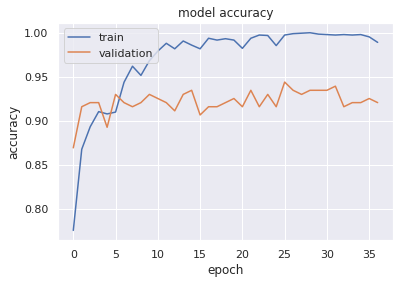

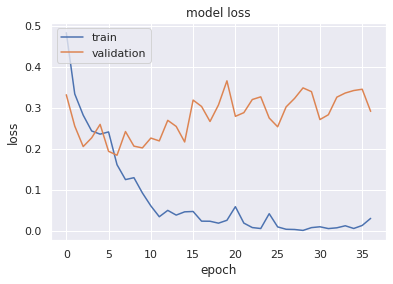

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_602169 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:C

{'Accuracy': 0.9051966292134831,
 'MCC': 0.8118752057102718,
 'log_loss': 0.40866372306394816,
 'f1 score': 0.9022447501810282,
 'roc_auc': 0.9051966292134832,
 'Precision': array([0.5       , 0.93124066, 1.        ]),
 'Recall': array([1.   , 0.875, 0.   ]),
 'sn': 0.875,
 'sp': 0.9353932584269663}

<Figure size 432x288 with 0 Axes>

In [15]:
train_tune = pd.concat([train, eval])
x_train_tune = pad_sequence(train_tune)
train_tune_y = pd.concat([train['label'], eval['label']])


dl=DeepML(x_train_tune, train_tune_y, x_test, test['label'], number_classes=2, problem_type='binary',
          x_dval=None, y_dval=None, epochs=500, batch_size=32,
          path='', report_name=None, verbose=1)
model = KerasClassifier(build_fn=veltri_model)
veltri = dl.run_model(model)
scores, report, cm, cm2 = dl.model_complete_evaluate()
scores

Just to demonstrate how a CV would be performed 

In [5]:
# join all data for Cross validation 10 
all_data = pd.concat([eval, train, test])
x_all_data = pad_sequence(all_data)

dl=DeepML(x_all_data, all_data['label'],
          x_test = None, y_test = None, 
          number_classes=2, problem_type='binary',
          x_dval=None, y_dval=None, 
          epochs=500, batch_size=32,
          path='', report_name=None, verbose=1)

model = KerasClassifier(build_fn=veltri_model)
veltri_cv = dl.train_model_cv(x_cv = x_all_data, y_cv = all_data['label'], cv=10, model=model)
veltri_cv


Fold  0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/de

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 31ms/step - loss: 0.3322 - accuracy: 0.8698 - val_loss: 0.3122 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 3/500
89/90 [============================>.] - ETA: 0s - loss: 0.3720 - accuracy: 0.8364Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDatase

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 33ms/step - loss: 0.0466 - accuracy: 0.9861 - val_loss: 0.3869 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 18/500
89/90 [============================>.] - ETA: 0s - loss: 0.0422 - accuracy: 0.9863Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 34ms/step - loss: 0.0576 - accuracy: 0.9809 - val_loss: 0.4758 - val_accuracy: 0.8938 - lr: 0.0010
Epoch 26/500
89/90 [============================>.] - ETA: 0s - loss: 0.0267 - accuracy: 0.9916Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDatas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 34ms/step - loss: 0.0140 - accuracy: 0.9958 - val_loss: 0.5042 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 34/500
90/90 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9969Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDatas

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_72813 in device /job:localhost/replica:0/task:0/device:GPU:0
90/90 [==============================] - 6s 69ms/step - loss: 0.4602 - accuracy: 0.7983 - val_loss: 0.3485 - val_accuracy: 0.8562 - lr: 0.0010
Epoch 2/500
89/90 [============================>.] - ETA: 0s - loss: 0.3515 - accuracy: 0.8634Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executi

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 35ms/step - loss: 0.2248 - accuracy: 0.9153 - val_loss: 0.2712 - val_accuracy: 0.9125 - lr: 0.0010
Epoch 10/500
90/90 [==============================] - ETA: 0s - loss: 0.2462 - accuracy: 0.9066Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDatas

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 35ms/step - loss: 0.0244 - accuracy: 0.9941 - val_loss: 0.4609 - val_accuracy: 0.8938 - lr: 0.0010
Epoch 25/500
90/90 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9937Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 34ms/step - loss: 0.0347 - accuracy: 0.9885 - val_loss: 0.5014 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 33/500
89/90 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9968Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDatas

Executing op __inference_train_function_110946 in device /job:localhost/replica:0/task:0/device:GPU:0
90/90 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.8066Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CP

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 35ms/step - loss: 0.1880 - accuracy: 0.9250 - val_loss: 0.2603 - val_accuracy: 0.9094 - lr: 0.0010
Epoch 9/500
89/90 [============================>.] - ETA: 0s - loss: 0.1490 - accuracy: 0.9421Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDatase

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 33ms/step - loss: 0.0647 - accuracy: 0.9781 - val_loss: 0.3616 - val_accuracy: 0.8813 - lr: 0.0010
Epoch 17/500
90/90 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9920Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDatas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 32ms/step - loss: 0.0165 - accuracy: 0.9948 - val_loss: 0.4616 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 25/500
90/90 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9892Executing op RangeDatas

Epoch 32/500
89/90 [============================>.] - ETA: 0s - loss: 0.0043 - accuracy: 0.9993Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 34ms/step - loss: 0.0043 - accuracy: 0.99

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/500
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 33ms/step - loss: 0.2002 - accuracy: 0.9309 - val_loss: 0.5364 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 7/500
89/90 [============================>.] - ETA: 0s - loss: 0.3105 - accuracy: 0.8792Executing op RangeDatase

Epoch 14/500
89/90 [============================>.] - ETA: 0s - loss: 0.1426 - accuracy: 0.9480Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 34ms/step - loss: 0.1429 - accuracy: 0.94

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 33ms/step - loss: 0.0464 - accuracy: 0.9858 - val_loss: 0.4287 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 22/500
89/90 [============================>.] - ETA: 0s - loss: 0.0486 - accuracy: 0.9870Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 35ms/step - loss: 0.0239 - accuracy: 0.9906 - val_loss: 0.5042 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 30/500
89/90 [============================>.] - ETA: 0s - loss: 0.0238 - accuracy: 0.9923Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDatas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 33ms/step - loss: 0.0052 - accuracy: 0.9990 - val_loss: 0.5273 - val_accuracy: 0.9156 - lr: 0.0010
Epoch 38/500
90/90 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9924Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDatas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 35ms/step - loss: 0.2610 - accuracy: 0.8997 - val_loss: 0.2701 - val_accuracy: 0.8938 - lr: 0.0010
Epoch 8/500
90/90 [==============================] - ETA: 0s - loss: 0.2178 - accuracy: 0.9212Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDatase

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 34ms/step - loss: 0.2012 - accuracy: 0.9274 - val_loss: 0.2062 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 16/500
90/90 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.9233Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDatas

Epoch 23/500
89/90 [============================>.] - ETA: 0s - loss: 0.1003 - accuracy: 0.9663Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 34ms/step - loss: 0.1017 - accuracy: 0.96

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 33ms/step - loss: 0.0778 - accuracy: 0.9740 - val_loss: 0.3667 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 31/500
89/90 [============================>.] - ETA: 0s - loss: 0.0541 - accuracy: 0.9853Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 35ms/step - loss: 0.0259 - accuracy: 0.9931 - val_loss: 0.3922 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 39/500
89/90 [============================>.] - ETA: 0s - loss: 0.0511 - accuracy: 0.9838Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDatas

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_221152 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 34ms/step - loss: 0.2497 - accuracy: 0.9028 - val_loss: 0.2740 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 5/500
89/90 [============================>.] - ETA: 0s - loss: 0.2107 - accuracy: 0.9224Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDatase

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 34ms/step - loss: 0.0713 - accuracy: 0.9771 - val_loss: 0.3126 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 13/500
89/90 [============================>.] - ETA: 0s - loss: 0.0470 - accuracy: 0.9863Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDatas

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 34ms/step - loss: 0.0261 - accuracy: 0.9934 - val_loss: 0.4156 - val_accuracy: 0.8938 - lr: 0.0010
Epoch 21/500
90/90 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9986Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDatas

Epoch 28/500
90/90 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9997Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 34ms/step - loss: 0.0030 - accuracy: 0.99

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 33ms/step - loss: 0.0158 - accuracy: 0.9944 - val_loss: 0.4647 - val_accuracy: 0.9094 - lr: 0.0010
Epoch 00035: early stopping
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 35ms/step - loss: 0.1046 - accuracy: 0.9660 - val_loss: 0.2896 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 12/500
89/90 [============================>.] - ETA: 0s - loss: 0.0518 - accuracy: 0.9856Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 32ms/step - loss: 0.0113 - accuracy: 0.9958 - val_loss: 0.4675 - val_accuracy: 0.8910 - lr: 0.0010
Epoch 20/500
90/90 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9983Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDatas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 35ms/step - loss: 0.0091 - accuracy: 0.9976 - val_loss: 0.4808 - val_accuracy: 0.9034 - lr: 0.0010
Epoch 28/500
89/90 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9951Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDatas

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 34ms/step - loss: 0.2888 - accuracy: 0.8878 - val_loss: 0.2659 - val_accuracy: 0.8941 - lr: 0.0010
Epoch 4/500
90/90 [==============================] - ETA: 0s - loss: 0.2568 - accuracy: 0.9000Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDatase

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 32ms/step - loss: 0.1566 - accuracy: 0.9424 - val_loss: 0.2702 - val_accuracy: 0.8910 - lr: 0.0010
Epoch 12/500
89/90 [============================>.] - ETA: 0s - loss: 0.1098 - accuracy: 0.9624Executing op RangeDatas

Epoch 19/500
89/90 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.9947Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 33ms/step - loss: 0.0199 - accuracy: 0.99

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 33ms/step - loss: 0.0215 - accuracy: 0.9920 - val_loss: 0.3630 - val_accuracy: 0.8972 - lr: 0.0010
Epoch 27/500
90/90 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.9948Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 32ms/step - loss: 0.0241 - accuracy: 0.9927 - val_loss: 0.3196 - val_accuracy: 0.9159 - lr: 0.0010
Epoch 35/500
90/90 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9910Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDatas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Fold  8
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 32ms/step - loss: 0.2343 - accuracy: 0.9069 - val_loss: 0.2409 - val_accuracy: 0.8879 - lr: 0.0010
Epoch 6/500
89/90 [============================>.] - ETA: 0s - loss: 0.1946 - accuracy: 0.9238Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatase

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 34ms/step - loss: 0.0651 - accuracy: 0.9785 - val_loss: 0.2878 - val_accuracy: 0.9128 - lr: 0.0010
Epoch 14/500
89/90 [============================>.] - ETA: 0s - loss: 0.0289 - accuracy: 0.9923Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDatas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 39ms/step - loss: 0.0371 - accuracy: 0.9910 - val_loss: 0.3490 - val_accuracy: 0.8972 - lr: 0.0010
Epoch 22/500
89/90 [============================>.] - ETA: 0s - loss: 0.0218 - accuracy: 0.9958Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDatas

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 34ms/step - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.5495 - val_accuracy: 0.8941 - lr: 0.0010
Epoch 37/500
89/90 [============================>.] - ETA: 0s - loss: 0.0122 - accuracy: 0.9972Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 33ms/step - loss: 0.2954 - accuracy: 0.8757 - val_loss: 0.3742 - val_accuracy: 0.8536 - lr: 0.0010
Epoch 4/500
90/90 [==============================] - ETA: 0s - loss: 0.3017 - accuracy: 0.8733Executing op RangeDatase

Epoch 11/500
90/90 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9622Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 35ms/step - loss: 0.0942 - accuracy: 0.96

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 34ms/step - loss: 0.0205 - accuracy: 0.9924 - val_loss: 0.3750 - val_accuracy: 0.9221 - lr: 0.0010
Epoch 19/500
89/90 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.9958Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 34ms/step - loss: 0.0084 - accuracy: 0.9965 - val_loss: 0.4836 - val_accuracy: 0.8972 - lr: 0.0010
Epoch 27/500
89/90 [============================>.] - ETA: 0s - loss: 0.0255 - accuracy: 0.9930Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDatas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
90/90 [==============================] - 3s 33ms/step - loss: 0.0049 - accuracy: 0.9979 - val_loss: 0.5152 - val_accuracy: 0.9097 - lr: 0.0010
Epoch 35/500
90/90 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9983Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDatas

Accuracy       MCC  log_loss  f1 score   roc_auc  \
0     0.898876  0.801863  0.429508  0.903743  0.898876   
1     0.896067  0.792448  0.479282  0.894587  0.896067   
2     0.938202  0.877791  0.371176  0.936416  0.938202   
3     0.887640  0.775477  0.460728  0.886364  0.887640   
4     0.915730  0.831461  0.329198  0.915730  0.915730   
5     0.907303  0.815237  0.466445  0.905444  0.907303   
6     0.881690  0.763378  0.546772  0.882022  0.881689   
7     0.878873  0.757864  0.703272  0.878187  0.878896   
8     0.912676  0.828273  0.388563  0.908555  0.912556   
9     0.923944  0.849493  0.345187  0.921283  0.923856   
mean  0.904100  0.809329  0.452013  0.903233  0.904082   
std   0.018103  0.036648  0.105214  0.017473  0.018085   

                                           Precision  \
0                     [0.5, 0.8622448979591837, 1.0]   
1                     [0.5, 0.9075144508670521, 1.0]   
2                     [0.5, 0.9642857142857143, 1.0]   
3                      [0.5, 0.896551724137931, 1.0]   
4                     [0.5, 0.9157303370786517, 1.0]   
5                     [0.5, 0.9239766081871345, 1.0]   
6      [0.5014084507042254, 0.8820224719101124, 1.0]   
7      [0.5014084507042254, 0.8857142857142857, 1.0]   
8     [0.49859154929577465, 0.9506172839506173, 1.0]   
9     [0.49859154929577465, 0.9518072289156626, 1.0]   
mean                  [0.5, 0.9140465003006344, 1.0]   
std                                              NaN   

                              Recall        sn        sp  
0      [1.0, 0.949438202247191, 0.0]  0.949438  0.848315  
1     [1.0, 0.8820224719101124, 0.0]  0.882022  0.910112  
2     [1.0, 0.9101123595505618, 0.0]  0.910112  0.966292  
3     [1.0, 0.8764044943820225, 0.0]  0.876404  0.898876  
4     [1.0, 0.9157303370786517, 0.0]  0.915730  0.915730  
5     [1.0, 0.8876404494382022, 0.0]  0.887640  0.926966  
6     [1.0, 0.8820224719101124, 0.0]  0.882022  0.881356  
7     [1.0, 0.8707865168539326, 0.0]  0.870787  0.887006  
8     [1.0, 0.8700564971751412, 0.0]  0.870056  0.955056  
9     [1.0, 0.8926553672316384, 0.0]  0.892655  0.955056  
mean  [1.0, 0.8936869167777568, 0.0]  0.893687  0.914477  
std                              NaN  0.023569  0.035535

After this first attempt, we tried different alternative configurations through a process of hyperparameter optimization, including the number of LSTM layers (1 or 2 LSTM layer), the units in LSTM layers (50, 100, 200, 300, 400 and
combinations), the number of convolutional layers (1 or 2) and number of filters in these layers (64, 32, 128), and the embedding size (128 or 64). None of these alterations significantly changed the accuracy or MCC. 
However, using a 300 unit LSTM layer instead of 100 yielded slightly better results. 
Here we present only the 

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHand

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in devi

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_4738968 in device /job:localhost/replica:0/task:0/device:GPU:0
45/45 [==============================] - 2s 39ms/step - loss: 0.5226 - accuracy: 0.7452
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execut

45/45 [==============================] - 2s 38ms/step - loss: 0.5170 - accuracy: 0.7468
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_4838556 in device /job:localhost/replica:0/task:0/

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_4928338 in device /job:localhost/replica:0/task:0/device:GPU:0
60/60 [==============================] - 6s 97ms/step - loss: 0.5553 - accuracy: 0.7732 - val_loss: 0.3451 - val_accuracy: 0.8645 - lr: 0.0010
Epoch 2/500
60/60 [==============================] - ETA: 0s - loss: 0.3623 - accuracy: 0.8608Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execut

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
60/60 [==============================] - 2s 42ms/step - loss: 0.1757 - accuracy: 0.9390 - val_loss: 0.2978 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 10/500
60/60 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.9656Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDatas

Epoch 17/500
59/60 [============================>.] - ETA: 0s - loss: 0.0408 - accuracy: 0.9905Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
60/60 [==============================] - 2s 40ms/step - loss: 0.0406 - accuracy: 0.99

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
60/60 [==============================] - 2s 41ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 0.6911 - val_accuracy: 0.8832 - lr: 0.0010
Epoch 25/500
60/60 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9979Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
60/60 [==============================] - 2s 40ms/step - loss: 0.0939 - accuracy: 0.9807 - val_loss: 0.4143 - val_accuracy: 0.8879 - lr: 0.0010
Epoch 33/500
59/60 [============================>.] - ETA: 0s - loss: 0.0244 - accuracy: 0.9926Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDatas

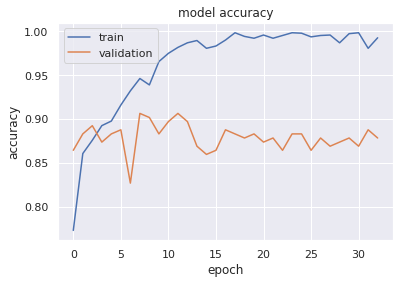

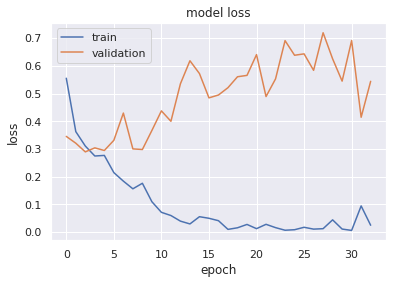

['Model with rank: 1\n', 'Mean validation score: 0.701 (std: 0.017)\n', "Parameters: {'units': 300}\n", '\n']
['Model with rank: 2\n', 'Mean validation score: 0.696 (std: 0.054)\n', "Parameters: {'units': 100}\n", '\n']
['Model with rank: 3\n', 'Mean validation score: 0.683 (std: 0.027)\n', "Parameters: {'units': 50}\n", '\n']
Best score (scorer: make_scorer(matthews_corrcoef)) and parameters from a 3-fold cross validation:

df
      means      stds  units
2  0.700750  0.017223    300
1  0.696434  0.053741    100
0  0.683175  0.027213     50


<Figure size 432x288 with 0 Axes>

In [58]:
train_tune = pd.concat([train, eval])
x_train_tune = pad_sequence(train_tune)
train_tune_y = pd.concat([train['label'], eval['label']])


dl=DeepML(x_train_tune, train_tune_y, x_test, test['label'], number_classes=2, problem_type='binary',
          x_dval=None, y_dval=None, epochs=500, batch_size=32,
          path='', report_name=None, verbose=1)

param_grid={'units':[50,100,300]}
model = KerasClassifier(build_fn=veltri_model)

dl.get_opt_params(param_grid=param_grid,  model=model, optType='gridSearch', cv=3, dataX=None, datay=None,
                       n_iter_search=15, n_jobs=1,
                       scoring=make_scorer(matthews_corrcoef))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/500
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executin

60/60 [==============================] - ETA: 0s - loss: 0.2648 - accuracy: 0.8994Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
60/60 [==============================] - 2s 41ms/step - loss: 0.2648 - accuracy: 0.8994 - val_loss

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
60/60 [==============================] - 2s 41ms/step - loss: 0.0609 - accuracy: 0.9828 - val_loss: 0.3726 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 14/500
60/60 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9807Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
60/60 [==============================] - 2s 40ms/step - loss: 0.0297 - accuracy: 0.9922 - val_loss: 0.4552 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 22/500
59/60 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9947Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDatas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
60/60 [==============================] - 2s 41ms/step - loss: 0.0096 - accuracy: 0.9974 - val_loss: 0.5344 - val_accuracy: 0.8925 - lr: 0.0010
Epoch 30/500
59/60 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9936Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDatas

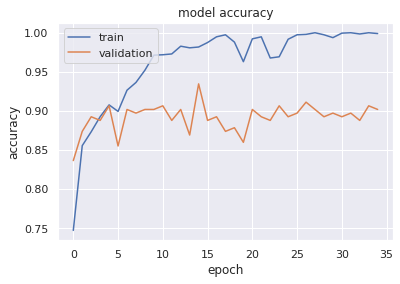

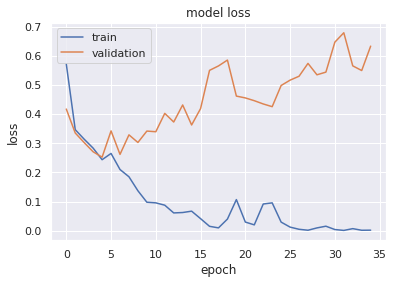

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_3248189 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:

{'Accuracy': 0.9115168539325843,
 'MCC': 0.8246097908870693,
 'log_loss': 0.5280139271465103,
 'f1 score': 0.9086956521739131,
 'roc_auc': 0.9115168539325843,
 'Precision': array([0.5       , 0.93862275, 1.        ]),
 'Recall': array([1.        , 0.88061798, 0.        ]),
 'sn': 0.8806179775280899,
 'sp': 0.9424157303370787}

<Figure size 432x288 with 0 Axes>

In [42]:
train_tune = pd.concat([train, eval])
x_train_tune = pad_sequence(train_tune)
train_tune_y = pd.concat([train['label'], eval['label']])

dl=DeepML(x_train_tune, train_tune_y, x_test, test['label'], number_classes=2, problem_type='binary',
          x_dval=None, y_dval=None, epochs=500, batch_size=32,
          path='', report_name=None, verbose=1)
model = KerasClassifier(build_fn=veltri_model, units=300)
veltri = dl.run_model(model)
scores, report, cm, cm2 = dl.model_complete_evaluate()
scores

Next, we used the same approach as the AmPEP case study and calculated features for the three datasets. To ease, we store them in files. The datasets were preprocessed (removed columns with invariance or only zeros) and standard scaler. 

In [24]:
# calculate features
def calculate_feature(data):
    list_feature = []
    count = 0
    for seq in data['seq']:
        count += 1
        res = {'seq': seq}
        sequence = ReadSequence()  # creating sequence object
        ps = sequence.read_protein_sequence(seq)
        protein = Descriptor(ps)  # creating object to calculate descriptors
        feature = protein.adaptable([19, 20, 21, 24, 26, 32], lamda_paac=10, lamda_apaac=10) #minimun len = 11
        # feature = protein.get_all(lamda_paac=5, lamda_apaac=5) #minimal seq len = 5
        # lambda should not be larger than len(sequence)
        res.update(feature)
        list_feature.append(res)
    df = pd.DataFrame(list_feature)
    print('feature calculated')
    return df

eval_feat = calculate_feature(eval)
train_feat = calculate_feature(train)
test_feat = calculate_feature(test)

eval_feat.to_csv('/home/amsequeira/propythia/propythia/example/AMP/datasets/eval_feat.csv', index=False)
train_feat.to_csv('/home/amsequeira/propythia/propythia/example/AMP/datasets/train_feat.csv', index=False)
test_feat.to_csv('/home/amsequeira/propythia/propythia/example/AMP/datasets/test_feat.csv', index=False)


feature calculated
feature calculated
feature calculated


In [90]:
eval_feat = pd.read_csv('/home/amsequeira/propythia/propythia/example/AMP/datasets/eval_feat.csv')
train_feat = pd.read_csv('/home/amsequeira/propythia/propythia/example/AMP/datasets/train_feat.csv')
test_feat = pd.read_csv('/home/amsequeira/propythia/propythia/example/AMP/datasets/test_feat.csv')

In [73]:
train_tune_feat = pd.concat([train_feat,eval_feat])
train_tune_feat = train_tune_feat.drop('seq', axis=1) # [2132 rows x 652 columns]
test_feat=test_feat.drop('seq', axis=1)

train_tune_y = pd.concat([train['label'], eval['label']])
test_y=test['label']

#  Preprocess
prepro = Preprocess()  # Create Preprocess object
x_train_clean, columns_deleted = prepro.preprocess(train_tune_feat, columns_names=True, threshold=0,
                                                 standard=True)  
test_feat_clean = test_feat[x_train_clean.columns]
scaler = StandardScaler().fit(x_train_clean)
X_train = scaler.transform(x_train_clean)
X_test = scaler.transform(test_feat_clean)

In [74]:
print('x_train: ', X_train.shape)
print('x_test: ', X_test.shape)

x_train:  (2132, 640)
x_test:  (1424, 640)


First we run a grid search hyperparameter optimization with number of estimators and max features.  Accuracy around the 0.91 and MCC 0.81, does not defer much from the scores obtained using deep learning models. 

In [85]:
ml = ShallowML(x_train=X_train, x_test=X_test, y_train=train_tune_y, y_test=test_y, report_name=None,
               columns_names=x_train_clean.columns)
param_grid = [{'clf__n_estimators': [10, 100, 200, 500], 'clf__max_features': ['sqrt', 'log2']}]
rf_all = ml.train_best_model('rf', score=make_scorer(matthews_corrcoef), param_grid=param_grid, cv=10, random_state = 55)
scores, report, cm, cm2 = ml.score_testset(rf_all)
scores

performing gridSearch...
GridSearchCV took 14.79 seconds for 8 candidate parameter settings.
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf',
                                        RandomForestClassifier(random_state=55))]),
             n_jobs=10,
             param_grid=[{'clf__max_features': ['sqrt', 'log2'],
                          'clf__n_estimators': [10, 100, 200, 500]}],
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.822 (std: 0.043)
 Parameters: {'clf__max_features': 'log2', 'clf__n_estimators': 500}
 

Model with rank: 2
 Mean validation score: 0.819 (std: 0.039)
 Parameters: {'clf__max_features': 'log2', 'clf__n_estimators': 200}
 

Model with rank: 3
 Mean validation score: 0.816 (std: 0.038)
 Parameters: {'clf__max_features': 'log2', 'clf__n_estimators': 100}
 

make_scorer(matthews_corrcoef)
10
Best score (scorer: make_scorer(matthews_corrcoef)) an

{'Accuracy': 0.9058988764044944,
 'MCC': 0.8118009555396923,
 'log_loss': 0.30674179656006373,
 'f1 score': 0.906030855539972,
 'roc_auc': 0.9058988764044943,
 'Precision': array([0.5      , 0.9047619, 1.       ]),
 'Recall': array([1.        , 0.90730337, 0.        ]),
 'fdr': 0.09523809523809523,
 'sn': 0.9073033707865169,
 'sp': 0.9044943820224719}

Analysis of features. The feature importance for RF performed with the Veltri dataset included general features linked to charge, isoelectric point, PAAC, APAAC, solvent accessibility, CTD features (however, not only D features and reflecting properties across the all the peptide sequence). 
Percentage of amino acids E, C, D are also in the top 20 features. These differences in the most relevant features may reflect the substantial differences between AmPEP and Veltri dataset

In [86]:
df = ml.features_importances_df(classifier=rf_all, model_name='rf', top_features=30,
                                column_to_sort='mean_coef')
df[:30]

importance
_ChargeC3                     0.028608
chargedensity                 0.019551
charge                        0.019354
_ChargeT23                    0.019327
IsoelectricPoint              0.018435
PAAC6                         0.014419
APAAC6                        0.013580
E                             0.012824
PAAC5                         0.012343
_SolventAccessibilityC1       0.011283
C                             0.011217
_ChargeD3100                  0.011158
D                             0.010893
_SolventAccessibilityD1100    0.010424
_PolarityC2                   0.010104
APAAC4                        0.010026
APAAC5                        0.009482
PAAC4                         0.009395
PAAC27                        0.008939
_ChargeD3075                  0.008918
_ChargeT12                    0.008757
_ChargeD3025                  0.007695
_ChargeD3001                  0.007469
_ChargeC1                     0.007390
APAAC12                       0.007386
formulaS                      0.007308
_SolventAccessibilityD1001    0.007295
_SolventAccessibilityD1075    0.006677
bomanindex                    0.006670
APAAC8                        0.006410

We also tried to use only the D frm CTD features in this dataset. Athough it achieved good results they were worst than using the whole set of features. 

In [91]:
train_tune_feat = pd.concat([train_feat,eval_feat])
train_tune_feat = train_tune_feat.drop('seq', axis=1) 

train_tune_y = pd.concat([train['label'], eval['label']])
test_y=test['label']

train_tune_feat = train_tune_feat.filter(regex=r'_.+D\d', axis=1) # 105
test_feat = test_feat.filter(regex=r'_.+D\d', axis=1)

ml = ShallowML(x_train=train_tune_feat, x_test=test_feat, y_train=train_tune_y, y_test=test_y, report_name=None,
               columns_names=train_tune_feat.columns)
rf_all = ml.train_best_model('rf', score=make_scorer(matthews_corrcoef), param_grid=None, cv=10)
scores, report, cm, cm2 = ml.score_testset()
scores


performing gridSearch...
GridSearchCV took 10.77 seconds for 6 candidate parameter settings.
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf',
                                        RandomForestClassifier(random_state=1))]),
             n_jobs=10,
             param_grid=[{'clf__bootstrap': [True], 'clf__criterion': ['gini'],
                          'clf__max_features': ['sqrt', 'log2'],
                          'clf__n_estimators': [10, 100, 500]}],
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.745 (std: 0.041)
 Parameters: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_features': 'log2', 'clf__n_estimators': 500}
 

Model with rank: 2
 Mean validation score: 0.740 (std: 0.052)
 Parameters: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'clf__n_estimators': 100}
 

Model with rank: 3
 Mean validation score: 0.739

{'Accuracy': 0.8651685393258427,
 'MCC': 0.7308245113630875,
 'log_loss': 0.36650153864211127,
 'f1 score': 0.8626609442060086,
 'roc_auc': 0.8651685393258426,
 'Precision': array([0.5       , 0.87900875, 1.        ]),
 'Recall': array([1.        , 0.84691011, 0.        ]),
 'fdr': 0.12099125364431487,
 'sn': 0.8469101123595506,
 'sp': 0.8834269662921348}

the D features are related to overall solvent accessibility, charge, normalizedVDWV, and polarity.

In [92]:
df = ml.features_importances_df(classifier=rf_all, model_name='rf', top_features=30,
                                column_to_sort='mean_coef')
df[:30]

importance
_SolventAccessibilityD1100    0.038538
_ChargeD3100                  0.033438
_ChargeD3075                  0.032110
_ChargeD3025                  0.029619
_ChargeD3050                  0.028354
_ChargeD3001                  0.028248
_SolventAccessibilityD1001    0.024332
_NormalizedVDWVD2100          0.023615
_SolventAccessibilityD1075    0.021993
_PolarityD2100                0.016774
_NormalizedVDWVD2075          0.016558
_PolarityD2001                0.016069
_ChargeD1025                  0.014459
_SolventAccessibilityD1050    0.014056
_PolarityD2075                0.013860
_PolarityD2050                0.013525
_SolventAccessibilityD3100    0.013139
_PolarityD3025                0.011231
_SolventAccessibilityD2075    0.011111
_PolarityD1001                0.011080
_HydrophobicityD1075          0.011060
_SolventAccessibilityD2100    0.010878
_PolarityD2025                0.010692
_SolventAccessibilityD3075    0.010443
_HydrophobicityD1100          0.010378
_ChargeD1001                  0.010149
_NormalizedVDWVD2050          0.009717
_HydrophobicityD3001          0.009539
_ChargeD1100                  0.009294
_NormalizedVDWVD2001          0.009168

Lastly, we performed a randomizedSearch hyperparameter optimization for a deep learnng model containing dense layers using all the features. The dataset is the same as performed the GidSearchRF. Similar to the RF, performed well but with worst results than the original approach. The values here reported are slightly different from ones described in the paper as a radomizedSearch was performed and the parameters evaluated were different. 

In [ ]:
train_tune_feat = pd.concat([train_feat,eval_feat])
train_tune_feat = train_tune_feat.drop('seq', axis=1) # [2132 rows x 652 columns]
test_feat=test_feat.drop('seq', axis=1)

train_tune_y = pd.concat([train['label'], eval['label']])
test_y=test['label']

#  Preprocess
prepro = Preprocess()  # Create Preprocess object
x_train_clean, columns_deleted = prepro.preprocess(train_tune_feat, columns_names=True, threshold=0,
                                                 standard=True)  
test_feat_clean = test_feat[x_train_clean.columns]
scaler = StandardScaler().fit(x_train_clean)
X_train = scaler.transform(x_train_clean)
X_test = scaler.transform(test_feat_clean)

dnn model simple
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:local

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:lo

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op AnonymousIteratorV2 in device /job:localhost/replic

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/ta

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_5594047 in device /job:localh

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_5612174 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 801us/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_5630301 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 875us/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

1/1 [==============================] - 0s 901us/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:lo

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
E

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in 

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:G

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/ta

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Execut

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_5877945 in device /job:localhost/replica:0/task:0/device:GPU:0
4/4 [==============================] - 0s 6ms/step - loss: 0.8969 - accuracy: 0.5451
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Exe

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_5901322 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 1ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMa

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_5939866 in device /job:localhost/replica:0/task:0/device:GPU:0
4/4 [==============================] - 0s 5ms/step - loss: 0.8010 - accuracy: 0.6178
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_5957481 in device /job:localhost/replica:0/task:0/device:GPU:0
4/4 [==============================] - 0s 5ms/step - loss: 0.7913 - accuracy: 0.6006
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executi

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/ta

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_6046684 in device /job:localh

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_6064299 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 1ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Re

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/devic

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_6120218 in device /job:localhost/replica:0/task:0/device:GPU:0
4/4 [==============================] - 0s 6ms/step - loss: 1.2415 - accuracy: 0.5746
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
E

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_6143547 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 1ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDatas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:G

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/ta

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Execut

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_6318299 in device /job:localhost/replica:0/task:0/device:GPU:0
4/4 [==============================] - 0s 6ms/step - loss: 1.2592 - accuracy: 0.5774
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Exe

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_6336106 in device /job:localhost/replica:0/task:0/device:GPU:0
4/4 [==============================] - 0s 5ms/step - loss: 0.7406 - accuracy: 0.6403
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execut

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

4/4 [==============================] - 0s 5ms/step - loss: 0.8126 - accuracy: 0.5652
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op P

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Exec

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_6442924 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 924us/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Exe

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_6460539 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 744us/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDat

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Execut

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_6516506 in device /job:localhost/replica:0/task:0/device:GPU:0
4/4 [==============================] - 0s 6ms/step - loss: 0.7080 - accuracy: 0.6502
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

1/1 [==============================] - 0s 977us/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:lo

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_6583997 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 777us/st

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/devic

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_6715019 in device /job:localhost/replica:0/task:0/device:GPU:0
4/4 [==============================] - 0s 6ms/step - loss: 0.7433 - accuracy: 0.5982
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

1/1 [==============================] - 0s 1ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:loca

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_6784670 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 862us/st

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/devic

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_6920012 in device /job:localhost/replica:0/task:0/device:GPU:0
4/4 [==============================] - 0s 6ms/step - loss: 5.6373 - accuracy: 0.6107
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

1/1 [==============================] - 0s 895us/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:lo

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
E

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Exec

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in dev

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_7087997 in device /job:localhost/replica:0/task:0/device:GPU:0
4/4 [==============================] - 0s 7ms/step - loss: 1.2018 - accuracy: 0.6113
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Exe

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

4/4 [==============================] - 0s 9ms/step - loss: 1.1964 - accuracy: 0.6191
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op P

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Exec

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_7197887 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 830us/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Exe

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_7216014 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 880us/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDat

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Execut

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2


Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_7359902 in device /job:localhost/replica:0/task:0/device:GPU:0
4/4 [==============================] - 0s 5ms/step - loss: 5.0513 - accuracy: 0.5941
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execut

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

4/4 [==============================] - 0s 5ms/step - loss: 5.0559 - accuracy: 0.6373
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op P

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Exec

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_7469792 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 851us/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Exe

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_7487919 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 1ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDatas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op 

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executi

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/d

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_7594671 in device /job:localhost/replica:0/task:0/device:GPU:0
4/4 [==============================] - 0s 4ms/step - loss: 0.6749 - accuracy: 0.6733
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/ta

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_7640656 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 978us/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op __inference_predict_function_7658783 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 661us/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchData

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Exec

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2


Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_7802671 in device /job:localhost/replica:0/task:0/device:GPU:0
4/4 [==============================] - 0s 5ms/step - loss: 1.5410 - accuracy: 0.5690
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execut

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_7830241 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 1000us/s

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

4/4 [==============================] - 0s 5ms/step - loss: 1.0323 - accuracy: 0.5571
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op P

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_7869904 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 955us/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Zip

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Exec

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Exec

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

1/1 [==============================] - 0s 1ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:loca

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/ta

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Exec

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_8094128 in device /job:localhost/replica:0/task:0/device:GPU:0
4/4 [==============================] - 0s 6ms/step - loss: 0.9824 - accuracy: 0.5253
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_8118225 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 1ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Re

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_8176048 in device /job:localhost/replica:0/task:0/device:GPU:0
4/4 [==============================] - 0s 4ms/step - loss: 0.8033 - accuracy: 0.5678
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
E

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_8203394 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 771us/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Exe

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/devi

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_8243009 in device /job:localhost/replica:0/task:0/device:GPU:0
1/1 [==============================] - 0s 835us/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDat

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op 

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executi

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GatherV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchD

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_8331912 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op AddN in device /job:localhost/replica:0/task:0/device:CPU:0
Ex

Epoch 4/500
1/4 [======>.......................] - ETA: 0s - loss: 4.3810 - accuracy: 0.8750Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executi

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 64ms/step - loss: 3.7953 - accuracy: 0.9286 - val_loss: 3.7827 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 9/500
1/

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/tas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 65ms/step - loss: 2.8233 - accuracy: 0.9703 - val_loss: 2.8981 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 16/500
1/4 [======>.......................] - ETA: 0s - loss: 2.7604 - accuracy: 0.9629Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Exec

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 65ms/step - loss: 1.9749 - accuracy: 0.9849 - val_loss: 2.1100 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 23/500
1/4 [======>.......................] - ETA: 0s - loss: 1.8967 - accuracy: 0.9902Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Tensor

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/devic

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 64ms/step - loss: 1.3116 - accuracy: 0.9932 - val_loss: 1.5222 - val_accuracy: 0.8972 - lr: 0.0010
Epoch 30/500
1/4 [======>.......................] - ETA: 0s - loss: 1.2541 - accuracy: 0.9961Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatase

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Epoch 37/500
1/4 [======>.......................] - ETA: 0s - loss: 0.8558 - accuracy: 0.9902Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execut

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 55ms/step - loss: 0.7340 - accuracy: 0.9891 - val_loss: 1.0873 - val_accuracy: 0.8224 - lr: 0.0010
Epoch 42/500
1

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/tas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 61ms/step - loss: 0.6270 - accuracy: 0.9885 - val_loss: 0.9731 - val_accuracy: 0.8224 - lr: 0.0010
Epoch 49/500
1/4 [======>.......................] - ETA: 0s - loss: 0.6491 - accuracy: 0.9766Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Exec

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 63ms/step - loss: 0.5529 - accuracy: 0.9896 - val_loss: 0.8992 - val_accuracy: 0.8318 - lr: 0.0010
Epoch 56/500
1/4 [======>.......................] - ETA: 0s - loss: 0.5437 - accuracy: 0.9883Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Tensor

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/devic

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 64ms/step - loss: 0.4783 - accuracy: 0.9927 - val_loss: 0.8551 - val_accuracy: 0.8178 - lr: 0.0010
Epoch 63/500
1/4 [======>.......................] - ETA: 0s - loss: 0.4730 - accuracy: 0.9961Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatase

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Epoch 70/500
1/4 [======>.......................] - ETA: 0s - loss: 0.4082 - accuracy: 0.9941Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execut

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 64ms/step - loss: 0.4207 - accuracy: 0.9838 - val_loss: 0.6817 - val_accuracy: 0.8832 - lr: 0.0010
Epoch 75/500
1

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/tas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 55ms/step - loss: 0.4237 - accuracy: 0.9885 - val_loss: 0.7177 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 82/500
1/4 [======>.......................] - ETA: 0s - loss: 0.4179 - accuracy: 0.9883Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Exec

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 55ms/step - loss: 0.3923 - accuracy: 0.9885 - val_loss: 0.6584 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 89/500
1/4 [======>.......................] - ETA: 0s - loss: 0.3740 - accuracy: 0.9922Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Tensor

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/devic

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 53ms/step - loss: 0.3332 - accuracy: 0.9891 - val_loss: 0.6291 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 96/500
1/4 [======>.......................] - ETA: 0s - loss: 0.3355 - accuracy: 0.9863Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatase

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Epoch 103/500
1/4 [======>.......................] - ETA: 0s - loss: 0.3379 - accuracy: 0.9902Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execu

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 53ms/step - loss: 0.3610 - accuracy: 0.9864 - val_loss: 0.6655 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 108/500


Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/tas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 54ms/step - loss: 0.3299 - accuracy: 0.9969 - val_loss: 0.6200 - val_accuracy: 0.8925 - lr: 0.0010
Epoch 115/500
1/4 [======>.......................] - ETA: 0s - loss: 0.3292 - accuracy: 0.9961Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Exec

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 53ms/step - loss: 0.2683 - accuracy: 0.9979 - val_loss: 0.5350 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 122/500
1/4 [======>.......................] - ETA: 0s - loss: 0.2564 - accuracy: 1.0000Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Tenso

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/devic

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 55ms/step - loss: 0.3203 - accuracy: 0.9797 - val_loss: 0.5808 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 129/500
1/4 [======>.......................] - ETA: 0s - loss: 0.3058 - accuracy: 0.9902Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Epoch 136/500
1/4 [======>.......................] - ETA: 0s - loss: 0.3478 - accuracy: 0.9902Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execu

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 54ms/step - loss: 0.3226 - accuracy: 0.9906 - val_loss: 0.6709 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 141/500


Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/tas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 55ms/step - loss: 0.2782 - accuracy: 0.9937 - val_loss: 0.6238 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 148/500
1/4 [======>.......................] - ETA: 0s - loss: 0.2720 - accuracy: 0.9980Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Exec

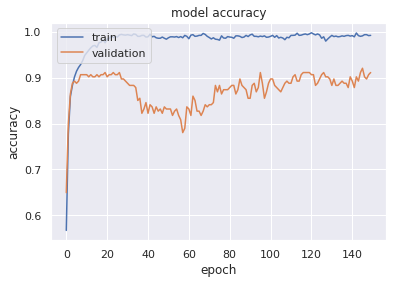

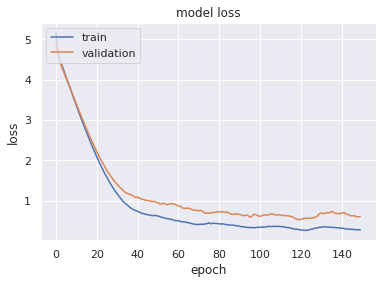

[['Model with rank: 1\n', 'Mean validation score: 0.585 (std: 0.065)\n', "Parameters: {'l2': 1e-05, 'l1': 0.001, 'hidden_layers': (128, 64), 'dropout_rate': 0.25}\n", '\n'], ['Model with rank: 2\n', 'Mean validation score: 0.558 (std: 0.066)\n', "Parameters: {'l2': 0, 'l1': 1e-05, 'hidden_layers': (128, 64), 'dropout_rate': 0.2}\n", '\n'], ['Model with rank: 3\n', 'Mean validation score: 0.548 (std: 0.106)\n', "Parameters: {'l2': 1e-05, 'l1': 1e-05, 'hidden_layers': (64,), 'dropout_rate': 0.25}\n", '\n']]
Best score (scorer: make_scorer(matthews_corrcoef)) and parameters from a 10-fold cross validation:

df
       means      stds       l2       l1  hidden_layers  dropout_rate
9   0.585320  0.064595  0.00001  0.00100      (128, 64)          0.25
2   0.558323  0.066241  0.00000  0.00001      (128, 64)          0.20
10  0.548405  0.105746  0.00001  0.00001          (64,)          0.25
12  0.540865  0.046657  0.00100  0.00000          (64,)          0.30
7   0.537390  0.121210  0.00010  0.

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
3/3 [==============================] - 0s 2ms/step


{'Accuracy': 0.9051966292134831,
 'MCC': 0.8120166913609925,
 'log_loss': 0.361916709889097,
 'f1 score': 0.902102973168963,
 'roc_auc': 0.9051966292134832,
 'Precision': array([0.5       , 0.93253373, 1.        ]),
 'Recall': array([1.        , 0.87359551, 0.        ]),
 'sn': 0.8735955056179775,
 'sp': 0.9367977528089888}

<Figure size 432x288 with 0 Axes>

In [93]:

dl = DeepML(x_train=X_train, y_train=train_tune_y, x_test=X_test, y_test=test_y, 
            x_dval=None, y_dval=None,
            number_classes=2, problem_type='binary', epochs=500, batch_size=512,
            path='', report_name=None, verbose=1)
dnn = dl.run_dnn_simple(
    input_dim=X_train.shape[1],
    optimizer='Adam',
    hidden_layers=(128, 64),
    dropout_rate=(0.3,),
    batchnormalization=(True,),
    l1=1e-5, l2=1e-4,
    final_dropout_value=0.3,
    initial_dropout_value=0.0,
    loss_fun=None, activation_fun=None,
    cv=10, optType='randomizedSearch', param_grid=None, n_iter_search=15, n_jobs=1,
    scoring=make_scorer(matthews_corrcoef))


scores, report, cm, cm2 = dl.model_complete_evaluate()
scores

dnn model simple
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Exec

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 61ms/step - loss: 4.0350 - accuracy: 0.9030 - val_loss: 3.9907 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 7/500
1/4 [======>.......................] - ETA: 0s - loss: 3.9171 - accuracy: 0.9277Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/devic

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 61ms/step - loss: 3.0607 - accuracy: 0.9463 - val_loss: 3.1043 - val_accuracy: 0.9159 - lr: 0.0010
Epoch 14/500
1/4 [======>.......................] - ETA: 0s - loss: 2.9739 - accuracy: 0.9512Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatase

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Epoch 21/500
1/4 [======>.......................] - ETA: 0s - loss: 2.0950 - accuracy: 0.9727Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execut

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 61ms/step - loss: 1.6396 - accuracy: 0.9833 - val_loss: 1.7941 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 26/500
1

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/tas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 63ms/step - loss: 1.0786 - accuracy: 0.9932 - val_loss: 1.2858 - val_accuracy: 0.9159 - lr: 0.0010
Epoch 33/500
1/4 [======>.......................] - ETA: 0s - loss: 1.0473 - accuracy: 0.9863Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Exec

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 61ms/step - loss: 0.7614 - accuracy: 0.9875 - val_loss: 1.0084 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 40/500
1/4 [======>.......................] - ETA: 0s - loss: 0.7371 - accuracy: 0.9883Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Tensor

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/devic

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 6s 2s/step - loss: 0.6433 - accuracy: 0.9833 - val_loss: 0.8779 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 47/500
1/4 [======>.......................] - ETA: 0s - loss: 0.6585 - accuracy: 0.9785Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset 

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Epoch 54/500
1/4 [======>.......................] - ETA: 0s - loss: 0.5388 - accuracy: 0.9922Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execut

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 59ms/step - loss: 0.5001 - accuracy: 0.9838 - val_loss: 0.7426 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 59/500
1

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/tas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 56ms/step - loss: 0.4542 - accuracy: 0.9917 - val_loss: 0.7496 - val_accuracy: 0.8879 - lr: 0.0010
Epoch 66/500
1/4 [======>.......................] - ETA: 0s - loss: 0.4552 - accuracy: 0.9902Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Exec

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 65ms/step - loss: 0.4438 - accuracy: 0.9864 - val_loss: 0.6653 - val_accuracy: 0.8972 - lr: 0.0010
Epoch 73/500
1/4 [======>.......................] - ETA: 0s - loss: 0.4250 - accuracy: 0.9941Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Tensor

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/devic

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 56ms/step - loss: 0.4052 - accuracy: 0.9906 - val_loss: 0.6445 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 80/500
1/4 [======>.......................] - ETA: 0s - loss: 0.4161 - accuracy: 0.9844Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatase

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Epoch 87/500
1/4 [======>.......................] - ETA: 0s - loss: 0.4070 - accuracy: 0.9961Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execut

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 54ms/step - loss: 0.4045 - accuracy: 0.9875 - val_loss: 0.6297 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 92/500
1

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/tas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 58ms/step - loss: 0.3558 - accuracy: 0.9922 - val_loss: 0.6011 - val_accuracy: 0.8972 - lr: 0.0010
Epoch 99/500
1/4 [======>.......................] - ETA: 0s - loss: 0.3382 - accuracy: 0.9961Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Exec

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 56ms/step - loss: 0.3506 - accuracy: 0.9906 - val_loss: 0.5907 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 106/500
1/4 [======>.......................] - ETA: 0s - loss: 0.3426 - accuracy: 0.9961Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Tenso

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/devic

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 58ms/step - loss: 0.3735 - accuracy: 0.9870 - val_loss: 0.5821 - val_accuracy: 0.9206 - lr: 0.0010
Epoch 113/500
1/4 [======>.......................] - ETA: 0s - loss: 0.3588 - accuracy: 0.9922Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Epoch 120/500
1/4 [======>.......................] - ETA: 0s - loss: 0.3613 - accuracy: 0.9902Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execu

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 54ms/step - loss: 0.3361 - accuracy: 0.9896 - val_loss: 0.5971 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 125/500


Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/tas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
4/4 [==============================] - 0s 53ms/step - loss: 0.2981 - accuracy: 0.9927 - val_loss: 0.6135 - val_accuracy: 0.8972 - lr: 0.0010
Epoch 00131: early stopping
('Training Accuracy mean: ', 0.9769201410635737) 
 ('Validation Accuracy mean: ', 0.9045088104619324) 
 ('Training Loss mean: ', 1.017719325218492) 
 ('Validation Loss mean: ', 1.2171469776685002)
Model: "sequential_267"
___________________

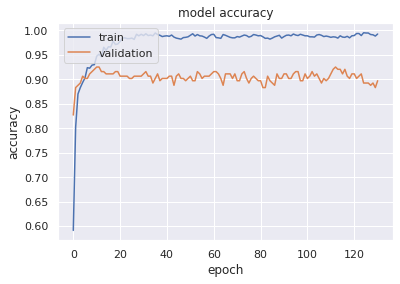

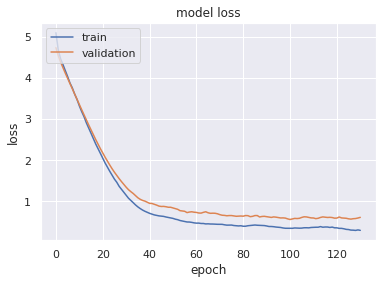

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Au

{'Accuracy': 0.9023876404494382,
 'MCC': 0.8047760746517086,
 'log_loss': 0.3115046506407159,
 'f1 score': 0.9024561403508771,
 'roc_auc': 0.9023876404494382,
 'Precision': array([0.5       , 0.90182328, 1.        ]),
 'Recall': array([1.        , 0.90308989, 0.        ]),
 'sn': 0.9030898876404494,
 'sp': 0.901685393258427}

<Figure size 432x288 with 0 Axes>

In [97]:
dl = DeepML(x_train=X_train, y_train=train_tune_y, x_test=X_test, y_test=test_y, 
            x_dval=None, y_dval=None,
            number_classes=2, problem_type='binary', epochs=500, batch_size=512,
            path='', report_name=None, verbose=1)
dnn = dl.run_dnn_simple(
    input_dim=X_train.shape[1],
    optimizer='Adam',
    hidden_layers=(128, 64),
    dropout_rate=0.3,
    batchnormalization=(True,),
    l1=0.001, l2=0,
    final_dropout_value=0.0,
    initial_dropout_value=0.0,
    loss_fun=None, activation_fun=None,
    cv=None, optType=None, param_grid=None, n_iter_search=15, n_jobs=1,
    scoring=make_scorer(matthews_corrcoef))


scores, report, cm, cm2 = dl.model_complete_evaluate()
scores